In [68]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
%matplotlib inline
plt.style.use('fivethirtyeight')

In [69]:
#读取数据 
data=pd.read_excel('data.xlsx') 
data=data.iloc[:,:]
choose='BASPL' #选取这一列
data.tail()

,年,月,ASPL,BME,BASPL,BLD,BLW,BJ,JN,LBL,SN,TJ,ST,SX,XMD,YXX
55,2019,8,3.763248e+06,62854.619304,8.599843e+07,1.650015e+08,3.481067e+08,1.060927e+06,2.359482e+06,13219.096853,6.456187e+05,1.758874e+08,2.961155e+07,1.949292e+07,56728.894684,107392.856432
56,2019,9,4.294952e+06,51559.590738,1.052790e+08,1.811433e+08,4.621942e+08,1.135383e+06,2.416740e+06,224849.311140,1.233509e+06,2.395380e+08,3.489288e+07,2.116995e+07,26868.589363,227671.344996
57,2019,10,2.835714e+06,31933.698695,8.023482e+07,1.674704e+08,3.022591e+08,1.023727e+06,2.074879e+06,32356.283055,4.381713e+05,1.561968e+08,2.178650e+07,1.655320e+07,32469.492085,134291.930366
58,2019,11,3.188248e+06,42248.757526,9.053573e+07,1.624495e+08,2.918764e+08,1.297557e+06,2.163609e+06,136809.701451,8.436577e+05,1.604672e+08,2.843713e+07,1.799922e+07,30197.836641,201416.711500
59,2019,12,4.437618e+06,67250.974962,1.034565e+08,1.545455e+08,2.355498e+08,1.336709e+06,2.369512e+06,246160.303870,6.326834e+05,1.424411e+08,2.360613e+07,1.968310e+07,20921.125742,157548.075168


Text(0.5, 1.0, 'BASPL')

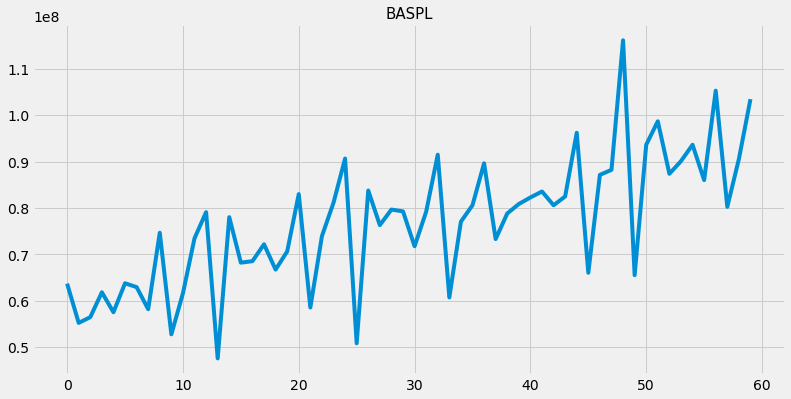

In [70]:
#展示一下看看
data=data[choose]
plt.figure(figsize=(12,6))
plt.plot(data)
#plt.grid()
plt.title(choose,fontsize='15') #添加标题

In [71]:
#构造针对机器学习模型的数据集
window=12#时间窗为12
data=data.values 
dataset=data
for i in range(window):
    zero=np.zeros(i+1)
    temp=np.append(data[i+1:],zero)
    dataset=np.row_stack((dataset,temp))
dataset=pd.DataFrame(dataset).T
dataset=dataset.iloc[:-window]
dataset=dataset/10000000#进行伪归一化
dataset.tail()#构造好的数据集如下

,0,1,2,3,4,5,6,7,8,9,10,11,12
43,8.246982,9.620531,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843
44,9.620531,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895
45,6.602126,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482
46,8.713054,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482,9.053573
47,8.821096,11.614596,6.550721,9.362264,9.868245,8.736202,9.008205,9.361410,8.599843,10.527895,8.023482,9.053573,10.345651


In [72]:
#划分特征与标签
x=dataset.iloc[:,:-1]
y=dataset.iloc[:,-1]
print(x.shape)
print(y.shape)

(48, 12)
(48,)


In [73]:
#构造训练集测试集
cut=6#取最后cut天为测试集
X_train, X_test=x.iloc[:-cut],x.iloc[-cut:]#列表的切片操作
y_train, y_test=y.iloc[:-cut],y.iloc[-cut:]
X_train,X_test,y_train,y_test=X_train.values,X_test.values,y_train.values,y_test.values
print(X_train.size)#通过输出训练集测试集的大小来判断数据格式正确。
print(X_test.size)
print(y_train.size)
print(y_test.size)

504
72
42
6


In [74]:
#以下函数均为对模型进行检验所用到的 精简代码的作用
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100
def up_down_accuracy(y_true, y_pred):
    y_var_test=y_true[1:]-y_true[:len(y_true)-1]#实际涨跌
    y_var_predict=y_pred[1:]-y_pred[:len(y_pred)-1]#原始涨跌
    txt=np.zeros(len(y_var_test))
    for i in range(len(y_var_test-1)):#计算数量
        txt[i]=np.sign(y_var_test[i])==np.sign(y_var_predict[i])
    result=sum(txt)/len(txt)
    return result
def output():
    #展示在测试集上的表现 
    draw=pd.concat([pd.DataFrame(y_test),pd.DataFrame(y_test_predict)],axis=1);
    draw.iloc[:,0].plot(figsize=(12,6))
    draw.iloc[:,1].plot(figsize=(12,6))
    plt.legend(('real', 'predict'),loc='upper right',fontsize='15')
    plt.title("Test Data",fontsize='30') #添加标题
    plt.show()
    #输出结果
    print('测试集上的MAE/MSE/MAPE/涨跌准确率')
    print(mean_absolute_error(y_test_predict, y_test))
    print(mean_squared_error(y_test_predict, y_test) )
    print(mape(y_test_predict,  y_test) )
    print(up_down_accuracy(y_test_predict,y_test))

In [75]:
#支持向量机及其结果
from sklearn.svm import LinearSVR  
svr = LinearSVR() 
model = svr.fit(X_train, y_train)
#在训练集上的拟合结果
y_train_predict=model.predict(X_train)
y_test_predict=model.predict(X_test)
error1=y_train_predict-y_train
var1=np.var(error1)

E:\anoconda\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


E:\anoconda\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  


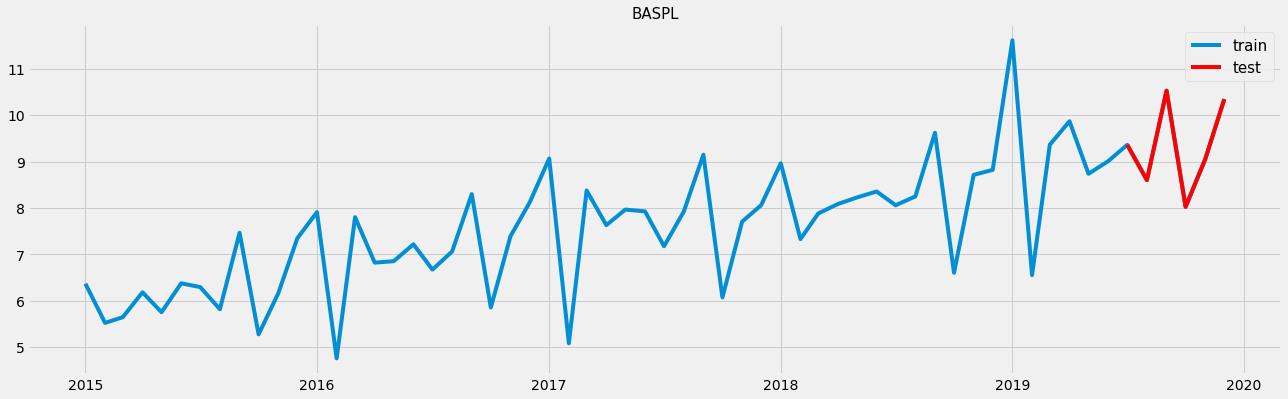

In [76]:
#展示一下看看
data=pd.read_excel('data.xlsx') 
data=data[choose]
data=data/10000000#进行伪归一化
#构建训练集测试集
cut=6#取最后cut天为测试集
data=pd.Series(data.values,\
                             index=pd.DatetimeIndex(start='2015-01-01',end='2019-12-01',freq='MS'))
y=data[:-cut]
true=data[-cut:]
plt.figure(figsize=(20,6))  # 创建图形
plt.plot(data)
plt.plot(true,color='red')
plt.legend(('train', 'test'),fontsize='15')
plt.title(choose,fontsize='15') #添加标题
#plt.grid()
plt.show()

In [77]:
#SARIMA模型 
#拟合模型+检验模型 残差不能相关
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
#在训练集上进行预测
pred = results.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
y_train_predict2 = pred.predicted_mean.values
y_train2 = y.values
y_train_predict2 = y_train_predict2[1:]
y_train2 = y_train2[1:]
error2=y_train_predict2-y_train2
var2=np.var(error2)
#在测试集上进行预测
pred_uc = results.get_forecast(steps=cut)  # retun out-of-sample forecast 
y_test_predict2=pred_uc.predicted_mean
y_test_predict2=y_test_predict2.values
y_test2=true.values

In [78]:
#计算系数
coef1=(1/var1)/(1/var1+1/var2)
coef2=(1/var2)/(1/var1+1/var2)
y_test_predict=y_test_predict*coef1+y_test_predict2*coef2

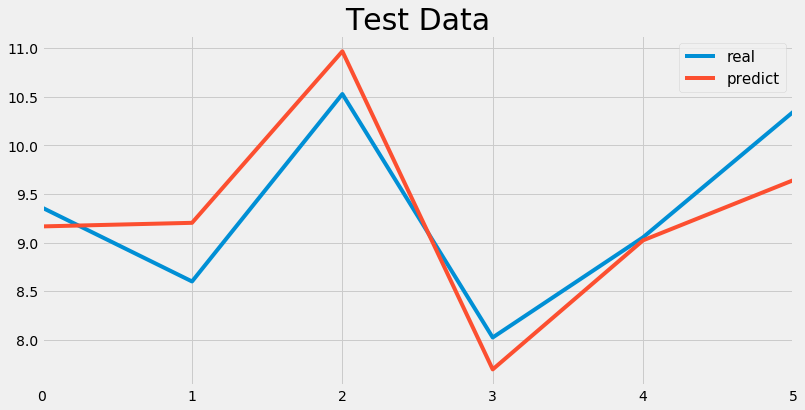

测试集上的MAE/MSE/MAPE/涨跌准确率
0.3834962939496644
0.19986397205513118
4.100019937094817
0.8


In [79]:
output()